## Import all the necessary libraries

In [89]:
import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm 
from sklearn.preprocessing import FunctionTransformer
import itertools    
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

## Load the keys to query the data. This step is omitted for Fall 2022 Hack 

In [2]:
import os
BIGQUERY_PROJECT = 'cloud-test-ironhacks'
BIGQUERY_KEYPATH = 'cloud-test-ironhacks-c1010c49a602.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = BIGQUERY_KEYPATH
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

## Query the data and see how they look like

In [3]:
query = """
SELECT * FROM `cloud-test-ironhacks.dwd_data.suppression_remove`

"""

query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
data = data[data['uu_id'].notnull() & data['total_claims'].notnull()]
data 

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
5,9bee42b55f891413ae7fac2d9d89280a,20220212,7,18003,100,"Census Tract 1, Allen County, Indiana",10.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
7,9bee42b55f891413ae7fac2d9d89280a,20220226,9,18003,100,"Census Tract 1, Allen County, Indiana",10.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
11,9bee42b55f891413ae7fac2d9d89280a,20220326,13,18003,100,"Census Tract 1, Allen County, Indiana",13.0,0.0,NaN,NaN,...,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
14,9bee42b55f891413ae7fac2d9d89280a,20220416,16,18003,100,"Census Tract 1, Allen County, Indiana",15.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,12.0
15,9bee42b55f891413ae7fac2d9d89280a,20220423,17,18003,100,"Census Tract 1, Allen County, Indiana",23.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72119,22804b1ddf209d3876385dd3ffa8392d,20220226,9,18065,976800,"Census Tract 9768, Henry County, Indiana",13.0,NaN,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
72123,22804b1ddf209d3876385dd3ffa8392d,20220326,13,18065,976800,"Census Tract 9768, Henry County, Indiana",11.0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
72147,22804b1ddf209d3876385dd3ffa8392d,20220903,36,18065,976800,"Census Tract 9768, Henry County, Indiana",29.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
72148,22804b1ddf209d3876385dd3ffa8392d,20220903,36,18065,976800,"Census Tract 9768, Henry County, Indiana",29.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0


In [4]:
data = data.sort_values('week_number')
data

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
39313,6239669cbfe444abd0a46536a670d150,20220101,1,18039,400,"Census Tract 4, Elkhart County, Indiana",16.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,13.0
34963,57bc30b16bd1a7875fc59a57c0363cd3,20220101,1,18097,356400,"Census Tract 3564, Marion County, Indiana",11.0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN
34819,8cb479dc5fba577ea3013a189045ff7b,20220101,1,18097,355700,"Census Tract 3557, Marion County, Indiana",16.0,0.0,NaN,12.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
7974,601ff2c0fd709298f6644ad0e766b2d6,20220101,1,18141,1100,"Census Tract 11, St. Joseph County, Indiana",13.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
34770,4fe5a3188b15f262431ed884f3619d8b,20220101,1,18097,355600,"Census Tract 3556, Marion County, Indiana",19.0,NaN,NaN,10.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008,bbcb018f0e5e49e13636f6e78ce9f60f,20221008,41,18163,10203,"Census Tract 102.03, Vanderburgh County, Indiana",22.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,18.0
14637,e24fca963ee2f4a4593900385e64051c,20221008,41,18095,12000,"Census Tract 120, Madison County, Indiana",11.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN
54325,6e34d7b45dd1daecd65ac963cd344e2d,20221008,41,18145,710500,"Census Tract 7105, Shelby County, Indiana",11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN
44100,9d137c34d4598e4f67aac16df77037e0,20221008,41,18089,42501,"Census Tract 425.01, Lake County, Indiana",30.0,0.0,NaN,17.0,...,12.0,18.0,0.0,0.0,0.0,18.0,NaN,NaN,NaN,NaN


## Cumulate the data according to the week_number. 

In [5]:
# predict week 39 with week 1 - week 38

df_week39_lag1 = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df_week39_lag1 = df_week39_lag1[df_week39_lag1['week_number'] < 39]

# predict week 40 with week 1 - week 39

df_week40_lag1 = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df_week40_lag1 = df_week40_lag1[df_week40_lag1['week_number'] < 40]

# predict week 41 with week 1 - week 40

df_week41_lag1 = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df_week41_lag1 = df_week41_lag1[df_week41_lag1['week_number'] < 41]

# predict week 39 with week 1 - week 36

df_week39_lag2 = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df_week39_lag2 = df_week39_lag2[df_week39_lag2['week_number'] < 37]

# predict week 40 with week 1 - week 37

df_week40_lag2 = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df_week40_lag2 = df_week40_lag2[df_week40_lag2['week_number'] < 38]

# predict week 41 with week 1 - week 40

df_week41_lag2 = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df_week41_lag2 = df_week41_lag2[df_week41_lag2['week_number'] < 39]

## Plot the overall data to see how the trend looks like when lagging 1 week 

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

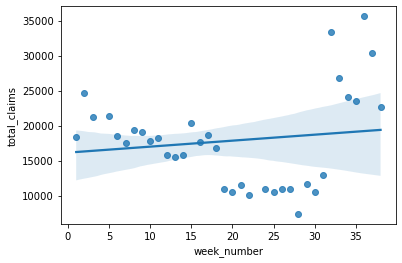

In [6]:
sns.regplot(df_week39_lag1['week_number'], df_week39_lag1['total_claims'])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

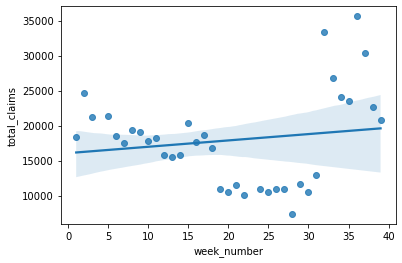

In [7]:
sns.regplot(df_week40_lag1['week_number'], df_week40_lag1['total_claims'])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

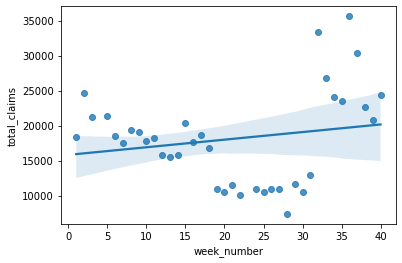

In [8]:
sns.regplot(df_week41_lag1['week_number'], df_week41_lag1['total_claims'])

## Plot the overall data to see how the trend looks like when lagging 2 weeks

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

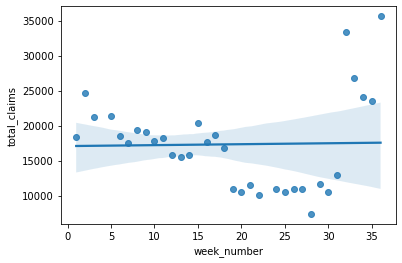

In [9]:
sns.regplot(df_week39_lag2['week_number'], df_week39_lag2['total_claims'])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

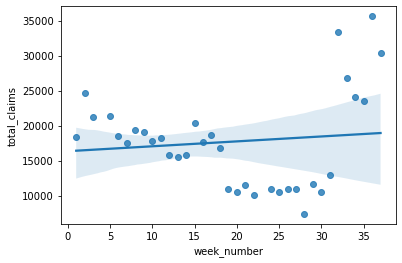

In [10]:
sns.regplot(df_week40_lag2['week_number'], df_week40_lag2['total_claims'])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

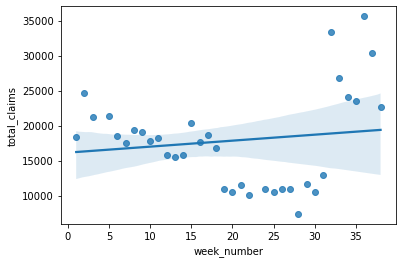

In [11]:
sns.regplot(df_week41_lag2['week_number'], df_week41_lag2['total_claims'])

## Start performing predictions on the overall data without the granularity from uu_id

> We do this primarily to decide if we should go with Linear Regression or Lag Regression. Note there are many ways to forecast which model might work better. 

In [12]:

X = df['week_number'].values.reshape(-1,1)
y = df['total_claims'].values.reshape(-1,1)

NameError: name 'df' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, random_state = 0)

In [ ]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

In [ ]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
outcome = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
outcome

In [ ]:
outcome = outcome.head(25)
outcome.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

## Start modeling with Lag Regression 

In [ ]:
df['lag'] = df['total_claims'].shift(1).dropna()
df

In [ ]:
X = df['lag'].dropna()
y = df['total_claims']
y, X = y.align(X, join='inner')  # drop corresponding values in target
X

In [ ]:
X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, random_state = 0)

regressor = LinearRegression().fit(X,y)

In [ ]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

## Now we decided we should use Linear Regression due to the better RMSE value. 

## Sort the dataframe 

> Sort the dataframe according to week_number so that we can use test_train_split directly on the top portion of the dataframe as the training set by setting stratify = False and shuffle = False. There are many ways to doing this. 

In [ ]:
data = data.sort_values('week_number')
data

## Function to print the dataframe according to the desired output format. 

In [13]:
def printexcel(result, filename):
    frame = pd.DataFrame(list(result.items()), columns=['uu_id','total_claims'])
    frame['total_claims'] =  frame['total_claims'].apply(lambda x: str(x).replace('[','').replace(']',''))
    frame['total_claims'] = frame['total_claims'].astype(float)
    frame.to_csv(filename, index=False)

## Function to predict week 52. 

In [92]:
week39  = data[data['week_number'] == 39]

In [93]:
data_week_38 = data[data['week_number'] < 39]

In [65]:
common = set(week39['uu_id']).intersection(data_week_38['uu_id'])

out = pd.concat([week39[week39['uu_id'].isin(common)], data_week_38[data_week_38['uu_id'].isin(common)]])
out = out.sort_values('week_number')
week_1_38 = out[out['week_number'] < 39]
week_39 = out[out['week_number'] == 39]

## Get only week 52 data 

In [70]:
def regressionsquare(data, yvar, xvars):
    X_train, X_test, y_train, y_test = train_test_split(data[xvars], data[yvar], train_size=0.9999, random_state=42, shuffle=False, stratify=None)
    result = sm.OLS(y_train, X_train).fit()
    predictions = result.predict(39)
    return predictions
result = week_1_38.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number')
print(result)

uu_id
005be9532fd717dc36d4be318fd9ad25     [54.01802943581359]
0068776d88cb6d1ab5c7059fbd3dd3cb     [77.86446568201565]
00d85dff1c1f21f01f4f5f0bd683d32b    [28.336013261500213]
00eefd4f45685ac82f7df022c30b3810     [32.84210526315789]
00f962ce727b8dbbf20925abd5a253dd     [53.51033499643623]
                                            ...         
fd38d1859753f17df3c5f4df40197795    [23.082101870775027]
fd536ceeba7fcbabdd0444b1eba6cab4    [28.882397003745318]
fd613eba867c6ad7350a937f743b88f2     [29.11840600265362]
fe355ff27aa8b2242a558d5e3ec99c18    [20.679226896215695]
fec479d0202d6e1e3f051a9ee902ff5d    [41.506170986982795]
Length: 574, dtype: object


In [71]:
result_dict1 = out.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number').to_dict()
printexcel(result_dict1, 'model-39-lag1.csv')

## Read the output file to compare actual and predicted value in week 52

In [72]:
df = pd.read_csv('model-39-lag1.csv')
df

,uu_id,total_claims
0,005be9532fd717dc36d4be318fd9ad25,51.940747
1,0068776d88cb6d1ab5c7059fbd3dd3cb,49.195960
2,00d85dff1c1f21f01f4f5f0bd683d32b,26.618454
3,00eefd4f45685ac82f7df022c30b3810,36.691313
4,00f962ce727b8dbbf20925abd5a253dd,53.851124
...,...,...
569,fd38d1859753f17df3c5f4df40197795,22.362984
570,fd536ceeba7fcbabdd0444b1eba6cab4,22.961089
571,fd613eba867c6ad7350a937f743b88f2,27.395214
572,fe355ff27aa8b2242a558d5e3ec99c18,19.709227


## Predicted value for week 39 ( lag 1 )

In [73]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [87]:
matching_39= week_39.loc[week_39['uu_id'].isin(df['uu_id'])]
matching_39 = matching_39.drop_duplicates('uu_id', keep='last')


In [86]:
mean_absolute_percentage_error(matching_39['total_claims'], df['total_claims'])

93.50752909362788

In [90]:
mean_squared_error(matching_39['total_claims'], df['total_claims'])

273.80165278148087

> Week 52 prediction not too bad

## Function to predict week 51

In [ ]:
def regressionsquare(data, yvar, xvars):
    X_train, X_test, y_train, y_test = train_test_split(data[xvars], data[yvar], train_size=0.9991, random_state=42, shuffle=False, stratify=None)
    result = sm.OLS(y_train, X_train).fit()
    predictions = result.predict(51)
    return predictions
result = data.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number')
print(result)

In [ ]:
result_dict1 = data.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number').to_dict()
printexcel(result_dict1, 'model-51.csv')

In [ ]:
df = pd.read_csv('model-51.csv')
df

## Actual value for week 51. Note, there is only one uu_id that has week 51 data. 

In [ ]:
result = data[data['week_number']== 51]['total_claims']
result

## Predicted value for week 51. Note, there is only one uu_id that has week 51 data

In [ ]:
result = df[df['uu_id']== 'e3e95cb95a379d758a44832a471c5350']['total_claims']
result

> Week 51 prediction a bit off, but not too bad either. 

## Function to predict week 49 

In [ ]:
def regressionsquare(data, yvar, xvars):
    X_train, X_test, y_train, y_test = train_test_split(data[xvars], data[yvar], train_size=0.9991, random_state=42, shuffle=False, stratify=None)
    result = sm.OLS(y_train, X_train).fit()
    predictions = result.predict(49)
    return predictions
result = data.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number')
print(result)

In [ ]:
result_dict1 = data.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number').to_dict()
printexcel(result_dict1, 'model-49.csv')

In [ ]:
df = pd.read_csv('model-49.csv')
df

## Actual value for week 49. Note, there is only two uu_id that has week 49 data. 

In [ ]:
result = data[data['week_number'] == 49]['total_claims']
result

## Predicted value for week 49. Note, there is only two uu_id that has week 49 data. 

In [ ]:
result = df[df['uu_id'] == 'a0875049afbd1cb4735e07c03fb8baae']['total_claims']
result

In [ ]:
result = df[df['uu_id'] == '7dd5fff353cd08adc694aa74d7fa31af']['total_claims']
result

> Model not too bad in predicting week 49 